# Code interpreter with IBM WatsonX AI Graphite

This example uses the [E2B SDK](https://github.com/e2b-dev/code-interpreter) as a code interpreter for [IBM Granite Code](https://www.ibm.com/granite/docs/models/code/) on [IBM WatsonX](https://www.ibm.com/watsonx).

The code generated by the LLM runs in a [E2B secure cloud sandbox](https://e2b.dev/docs/sandbox/overview).
>

### 1. Dependencies
First, we install IBM WatsonX AI, OpenAI, and the E2B Code Interpreter SDK.

In [8]:
%pip install -q e2b_code_interpreter==1.0.5 python-dotenv==1.0.1 ibm_watsonx_ai==1.2.9


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 2. API Keys

You need to get your API keys and save them in .env file. You can copy and rename the .env.template file. We import all necessary libraries.

This is what you should put in the .env file:

```sh
# Get your credentials at dataplatform.cloud.ibm.com:
# - Under developer access, select the default project
# - Get the project ID
# - Get the wastonxai URL
# - Create an API key
WATSONX_PROJECT_ID = "project_id"
WATSONX_URL = "https://region.ml.cloud.ibm.com"
WATSONX_API_KEY = "your_api_key"

# Get your API key at e2b.dev:
E2B_API_KEY = "your_api_key"
```

In [1]:
import os
from dotenv import load_dotenv

# Environment Setup
load_dotenv()

True

### 3. Initialize WatsonX AI Client

We initialize the WatsonX AI client using the credentials stored in the environment variables. This client will be used to interact with the IBM WatsonX Granite model.

In [2]:
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import ModelInference

# Environment variables
WATSONX_PROJECT_ID = os.getenv("WATSONX_PROJECT_ID")
WATSONX_URL = os.getenv("WATSONX_URL")
WATSONX_API_KEY = os.getenv("WATSONX_API_KEY")
E2B_API_KEY = os.getenv("E2B_API_KEY")

# Initialize WatsonX client
credentials = Credentials(
    url=WATSONX_URL,
    api_key=WATSONX_API_KEY,
)
client = APIClient(credentials)

# Initialize model
model = ModelInference(
    model_id="ibm/granite-34b-code-instruct",
    api_client=client,
    project_id=WATSONX_PROJECT_ID,
    params={"max_new_tokens": 1024},
)

print("Model initialized:", model)

Model initialized: <ibm_watsonx_ai.foundation_models.inference.model_inference.ModelInference object at 0x107298a90>


### 4. Configure System Prompt and Generate a Response
We define a system prompt that instructs the model on how to behave. Then, we send a user query to the model and retrieve a response.

In [3]:
# System prompt configuration
# Because this is Markdown, the LLM will respond in Markdown
SYSTEM_PROMPT = """
## Your job & context
You are a python data scientist. You are given tasks to complete and you run Python code to solve them.
- The Python code runs in Jupyter notebook.
- You have access to the internet and can make API requests.
- You also have access to the filesystem and can read/write files.
- You can install any pip package but the usual packages for data analysis are already preinstalled.
"""

# Specify the prompt
user_message = "Plot a 3D chart of sin x cos y."
print(f"User Message: {user_message}")

prompt = SYSTEM_PROMPT + user_message + "\n"

# Generate response
content = model.generate_text(prompt)

print(f"Model response:")
print(f"{'='*50}\n{content}\n{'='*50}")

User Message: Plot a 3D chart of sin x cos y.
Model response:

## Your code
```python
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 2 * np.pi, 100)
y = np.linspace(0, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

plt.show()
```


### 5. Extract and Display AI-Generated Code

The AI-generated response may include Markdown formatting. We extract the code block from the response using regular expressions.

In [4]:
import re

# Extract code blocks
pattern = re.compile(r"```(?:python)?[\n\r](.*?)```", re.DOTALL)
results = pattern.findall(content)
code_block = "\n".join(results) if results else content

# Print the code block
print(f"AI-generated code:")
print(f"{'='*50}\n{code_block}\n{'='*50}")

AI-generated code:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 2 * np.pi, 100)
y = np.linspace(0, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

plt.show()



### 6. Execute Code in an E2B Code Interpreter

We run the AI-generated code in a secure E2B sandbox environment, capturing its output, errors, and runtime exceptions.

In [ ]:
from e2b_code_interpreter import Sandbox

# Run the code in an E2B code interpreter
code_interpreter = Sandbox(api_key=E2B_API_KEY)
result = code_interpreter.run_code(
    code_block,
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
)

# Print results
print("Stdout:", result.logs.stdout)
print("Stderr:", result.logs.stderr)
print("Python runtime error:", result.error)

Stdout: []
Stderr: []
Python runtime error: None


### 7. Display Generated Figures

If the AI-generated code produces visualizations, we render and display them in the notebook.

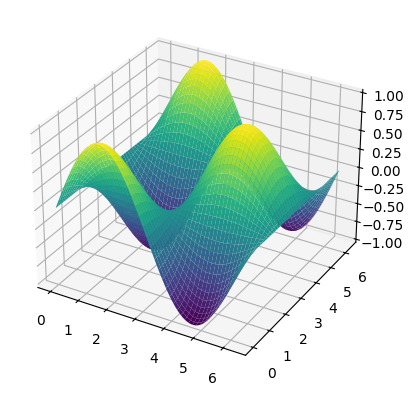

[None]

In [6]:
from IPython.display import display

# Display all figures
[display(figure) for figure in result.results]

### 8. Terminate the Code Interpreter

Finally, we safely terminate the E2B code interpreter to free up resources.

In [7]:
# Kill the code interpreter
code_interpreter.kill()